In [1]:
import pandas as pd
import json
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
import re
import tensorflow_text as tf_text

2024-04-24 15:48:58.060905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 15:48:58.061054: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 15:48:58.189626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
csv = pd.read_csv("/kaggle/input/hack-train/hack_train.csv")
csvFull = csv.rename(columns={'text': 'answers', "label" : "is_human"})
answers_df = csvFull.drop(columns="src")
# Checking the len
answers_df = answers_df.explode('answers', ignore_index=True)
answers_df = answers_df.dropna(subset=['answers'], ignore_index=True)

answers_df

,answers,is_human
0,Little disclaimer: this deals with US laws and...,1
1,"Read: Mentally Retarded Downs. See, we've got ...",1
2,"If any of you frequent rbadhistory, there is a...",1
3,"I believe in a flat tax system, where everyone...",1
4,"Edit: Ok guy's, my views have been changed on ...",1
...,...,...
56814,We consider the recovery of a source term f (x...,1
56815,"Self-supervised learning (SlfSL), aiming at le...",1
56816,Recurrent neural networks (RNNs) have achieved...,1
56817,Deep reinforcement learning (DRL) is a booming...,1


In [3]:
def Clean(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)
    text = tf.strings.regex_replace(text, '\.\.\.', ' ')
    text = tf.strings.join(['',text, ''], separator=' ')
    return text
def clean_text(text):
    # Remove Twitter handles starting with '@'
    text = re.sub(r'@\w+', '', text)
    # Remove non-alphanumeric characters and extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert multiple whitespace characters to a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    return text

In [4]:
max_features = 75000
embedding_dim = 64
sequence_length = 512*2
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=Clean ,
    max_tokens=max_features,
    ngrams = (3,5),
    output_mode="int",
    output_sequence_length=sequence_length,
    pad_to_max_tokens=True
)
vectorize_layer.adapt(answers_df['answers'])
Text = vectorize_layer(answers_df['answers']).numpy()
Text

array([[66648, 69019, 63364, ...,     1,     1,     1],
       [    1,     1,     1, ...,     0,     0,     0],
       [11915, 20370, 65784, ...,     0,     0,     0],
       ...,
       [25173,     1,     1, ...,     0,     0,     0],
       [35435,     1,     1, ...,     0,     0,     0],
       [  419,     1,     1, ...,     0,     0,     0]])

In [5]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=44)
X,y= sm.fit_resample(Text,answers_df['is_human'])

In [6]:
#X = answers_df['answers']
#y = answers_df['is_human']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (45985, 1024)
X_test shape is  (11497, 1024)
y_train shape is  (45985,)
y_test shape is  (11497,)


In [7]:
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import TextVectorization, Embedding, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Dense, Dropout

import tensorflow as tf

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        config = super().get_config()
        config["att"] = self.att
        config["ffn"] = self.ffn
        config["layernorm1"] = self.layernorm1
        config["layernorm2"] = self.layernorm2
        config["dropout1"] = self.dropout1
        config["dropout2"] = self.dropout2
        return config

inputs = Input(shape=(sequence_length,), dtype="int64")
x = Embedding(max_features, embedding_dim)(inputs)
x = Bidirectional(LSTM(32, return_sequences=True))(x)
transformer_block = TransformerBlock(embedding_dim, 2, 32)
x = transformer_block(x, training=True)
x = Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid", name="predictions")(x)

model = Model(inputs=inputs, outputs=predictions)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 1024, 64)       │     4,800,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1024, 64)       │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 1024, 64)       │        37,664 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 340, 128)       │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,936,609 (18.83 MB)

 Trainable params: 4,936,609 (18.83 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

checkpoint_cb =ModelCheckpoint("model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=5, validation_split=.1, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 150s 108ms/step - accuracy: 0.8845 - loss: 0.3238 - val_accuracy: 0.9306 - val_loss: 0.2221
Epoch 2/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 139s 107ms/step - accuracy: 0.9500 - loss: 0.1794 - val_accuracy: 0.9306 - val_loss: 0.2123
Epoch 3/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 139s 107ms/step - accuracy: 0.9645 - loss: 0.1420 - val_accuracy: 0.9326 - val_loss: 0.2342
Epoch 4/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 139s 107ms/step - accuracy: 0.9752 - loss: 0.1045 - val_accuracy: 0.9319 - val_loss: 0.2683
Epoch 5/5
1294/1294 ━━━━━━━━━━━━━━━━━━━━ 139s 107ms/step - accuracy: 0.9786 - loss: 0.0884 - val_accuracy: 0.9267 - val_loss: 0.3469


In [9]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.914391,0.269310,0.930637,0.222100
1,0.949959,0.178771,0.930637,0.212273
2,0.964795,0.139450,0.932594,0.234155
3,0.974557,0.107834,0.931942,0.268254
4,0.977384,0.091803,0.926723,0.346895


In [10]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.9272 - loss: 0.2213
Test Loss = 0.22001267969608307
Test Accuracy = 0.9254587888717651


In [11]:
import numpy as np 
predictions = model.predict(X_test)
y_pred = np.where(predictions>=.5,1,0)
y_test_1d = np.ravel(y_test)
y_pred_1d = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test_1d, 'Prediction': y_pred_1d})
df

360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step


,Actual,Prediction
0,1,1
1,1,1
2,0,0
3,0,0
4,1,0
...,...,...
11492,0,0
11493,1,1
11494,0,0
11495,1,1


array([[5391,  308],
       [ 549, 5249]])

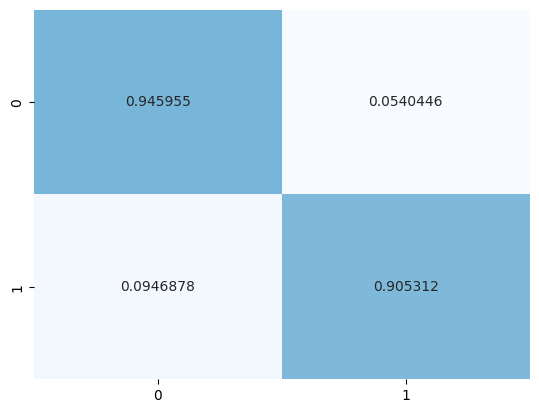

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(y_test_1d,y_pred_1d)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [13]:
from sklearn.metrics import classification_report
ClassificationReport = classification_report(y_test_1d,y_pred_1d)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.91      0.95      0.93      5699
           1       0.94      0.91      0.92      5798

    accuracy                           0.93     11497
   macro avg       0.93      0.93      0.93     11497
weighted avg       0.93      0.93      0.93     11497



In [14]:
model.save_weights('my_model.weights.h5')